# Hierarchical Clustering - Customer Dataset

- Virginia Ordoño 
- May 2024

El conjunto de datos adjunto contiene información sobre los clientes de un centro comercial. Cada fila representa a un cliente y las columnas contienen diferentes características o atributos sobre ellos:, como edad, ingreso anual, puntaje de gasto (una medida de cuánto gastan en el centro comercial), etc.

Edad: Edad del cliente.
Ingreso anual: Ingreso anual del cliente en miles de dólares.
Puntaje de gasto: Puntaje asignado al cliente en función de su historial de gastos en el centro comercial (en una escala del 1 al 100).
Con este conjunto de datos emplea clustering jerárquico con el objetivo de segmentar a los clientes en diferentes grupos basados en sus características, lo que puede ayudar al centro comercial a comprender mejor a su base de clientes y personalizar sus estrategias de marketing y ventas.

Además, visualiza los resultados utilizando un dendrograma y establece un punto de corte óptimo.

P.D.- Seleccionar el número óptimo de clusters observando el dendrograma es un proceso visual que implica identificar los cortes en el dendrograma donde la altura del corte muestra una separación clara entre los clusters. Estos cortes representan divisiones significativas en los clusters. Busca cortes que formen grupos coherentes de datos y evita cortes que dividan grupos grandes en clusters demasiado pequeños.

## 1. Carga de datos

In [1]:
import pandas as pd  # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore


data_csv = '../data/customers.csv'
df = pd.read_csv(data_csv)
df.columns = df.columns.str.replace(' ', '_').str.lower()

df.T

,0,1,2,3,4,5,6,7,8,9,...,348,349,350,351,352,353,354,355,356,357
edad,19,21,20,23,31,22,35,23,64,30,...,41,36,34,32,33,38,47,35,45,32
ingreso_anual,15,15,16,16,17,17,18,18,19,19,...,137,137,137,137,137,137,137,137,137,137
puntaje_gasto,39,81,6,77,40,76,6,94,3,72,...,17,85,23,69,8,91,16,79,28,74


In [2]:
df.shape

(358, 3)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   edad           358 non-null    int64
 1   ingreso_anual  358 non-null    int64
 2   puntaje_gasto  358 non-null    int64
dtypes: int64(3)
memory usage: 8.5 KB


## 2. Comprobación de  datos

### Gestión de duplicados

In [4]:
# Los dejamos porque es posible en este caso

if df.duplicated().any():
    duplicated_rows = df[df.duplicated(keep=False)]  # keep=False para marcar todas las filas duplicadas
    print(duplicated_rows)

     edad  ingreso_anual  puntaje_gasto
198    32            137             18
199    30            137             83
200    34            137             15
201    30            137             88
202    29            137              7
..    ...            ...            ...
353    38            137             91
354    47            137             16
355    35            137             79
356    45            137             28
357    32            137             74

[160 rows x 3 columns]


### Gestión de nulos

In [5]:
if (df.isna().sum() > 0).any():
    print(df.isna().sum()[df.isna().sum() > 0])

### Escalamiento de los datos


En clustering jerárquico, es común aplicar la estandarización de los datos numéricos utilizando la estandarización z-score (también conocida como estandarización estándar). Esto implica restar la media de cada característica y luego dividir por la desviación estándar de esa característica.

In [6]:
from sklearn.preprocessing import StandardScaler # type: ignore

df_base = df.copy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_base)
df_base = pd.DataFrame(scaled_features, columns=df_base.columns)

df_base.head()

,edad,ingreso_anual,puntaje_gasto
0,-1.580306,-1.856629,-0.430833
1,-1.411274,-1.856629,1.004577
2,-1.495790,-1.833215,-1.558655
3,-1.242242,-1.833215,0.867871
4,-0.566115,-1.809801,-0.396657


## 3. Ejecución del algoritmo jerárquico - Distancia 'Centroids'

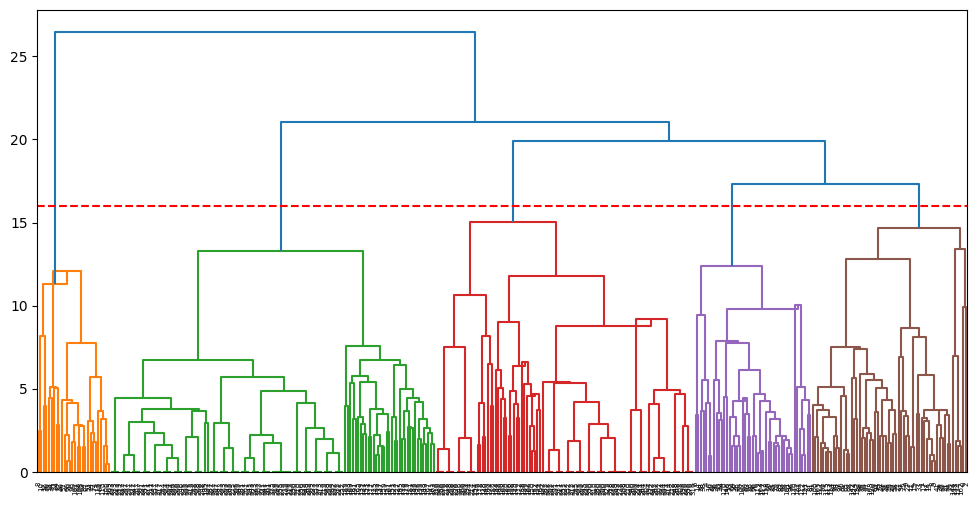

In [7]:
from sklearn.metrics.pairwise import euclidean_distances # type: ignore
from scipy.cluster import hierarchy # type: ignore
from scipy.spatial.distance import pdist # type: ignore

# Calcular la matriz de distancias euclidianas entre los datos
distance_matrix = euclidean_distances(df_base)

# Establecemos el umbral de distancia para el clustering jerárquico
THRESHOLD = 16

# Dibujamos el dendrograma
plt.figure(figsize=(12, 6))

# Matriz que contiene la información de los clusters que se van formando: 
# índices, distancia, número de elementos
# pdist. transforma la matriz de distancias en un vector de distancias
clusters_matrix = hierarchy.linkage(pdist(distance_matrix), method='centroid')
hierarchy.dendrogram(clusters_matrix, color_threshold=THRESHOLD)
plt.axhline(y=THRESHOLD, color='r', linestyle='--')  
plt.show();

In [8]:
from scipy.cluster.hierarchy import fcluster # type: ignore

# Obtener los clusters (grupos) basados en el dendrograma y el umbral de distancia
cluster_labels = fcluster(clusters_matrix, t=THRESHOLD, criterion='distance')

# Número total de clusters
num_clusters = len(set(cluster_labels))

print(f"Número de grupos: {num_clusters}")
print(f"Grupos obtenidos: {set(cluster_labels)}")

Número de grupos: 5
Grupos obtenidos: {1, 2, 3, 4, 5}


## 4. Análisis con PCA

In [9]:
from sklearn.decomposition import PCA # type: ignore

pca = PCA(n_components=2)
X_pca  = pca.fit_transform(df_base)
print(f'Proporción de varianza: {pca.explained_variance_ratio_}')

component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]

X_pca = pd.DataFrame(
    X_pca, 
    columns=component_names)

X_pca['cluster'] = cluster_labels

X_pca.head()

Proporción de varianza: [0.46249948 0.32444346]


,PC1,PC2,cluster
0,-0.298697,1.847193,5
1,-1.145712,2.208591,5
2,0.510428,1.515411,5
3,-0.943644,2.130110,5
4,0.365456,1.692824,4


### Loadings con PCA

Tabla para interpretar y entender cómo cada característica original está relacionada con los componentes principales obtenidos a través de PCA. Los loadings más altos indican una mayor influencia de la característica en la definición del componente principal correspondiente.

In [10]:

loadings = pd.DataFrame(
    pca.components_.T,  # Invierte las filas y columnas
    columns=component_names,  # Las columnas serán los componentes principales
    index=df_base.columns,  # Los nombres de las filas serán los nombres de las características
)
loadings

,PC1,PC2
edad,0.689979,-0.116972
ingreso_anual,-0.270623,-0.956976
puntaje_gasto,-0.671336,0.265547


### Visualización con PCA

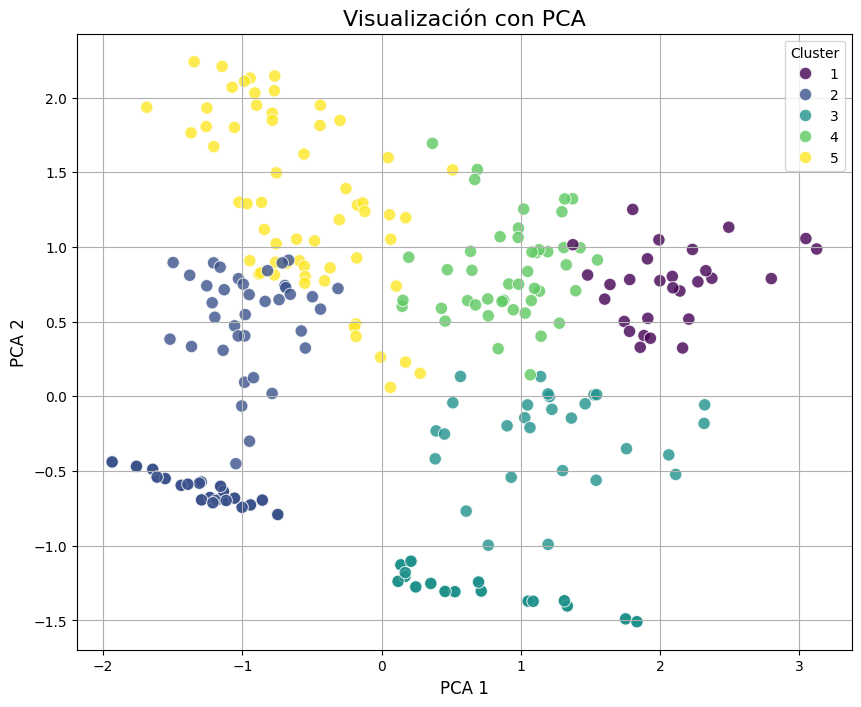

In [11]:
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

# Graficar los puntos coloreados por cluster
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=X_pca, hue='cluster', palette='viridis', legend='full', alpha=0.8, s=80)

# Agregar título y etiquetas
plt.title('Visualización con PCA', fontsize=16)
plt.xlabel('PCA 1', fontsize=12)
plt.ylabel('PCA 2', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)

plt.show()